# Neural Network Model Analysis on House Prices

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels, device):
        self.features = features.to(device)
        self.labels = labels.to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [4]:
# Load the data
X_train = pd.read_csv('./data/X_train.csv').values
y_train = pd.read_csv('./data/y_train.csv').values.squeeze()
X_test = pd.read_csv('./data/X_test.csv').values
y_test = pd.read_csv('./data/y_test.csv').values.squeeze()

# split train into train and validation
X_train_model_selection, X_val, y_train_model_selection, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4244997347)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train_model_selection_tensor = torch.tensor(X_train_model_selection, dtype=torch.float32)
y_train_model_selection_tensor = torch.tensor(y_train_model_selection, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


# Create custom datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, device)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor, device)
train_model_selection_dataset = CustomDataset(X_train_model_selection_tensor, y_train_model_selection_tensor, device)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor, device)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
train_model_selection_loader = DataLoader(dataset=train_model_selection_dataset, batch_size=len(train_model_selection_dataset), shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=False)

In [5]:
def forward_block(input_dim, output_dim, leaky_param=0.0, dropout_p=0.0, final_layer=False):
    if final_layer is False:
        return nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(leaky_param,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_dim, output_dim)
        )


# Neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_dim, layers, leaky_param, dropout_p):
        super(NeuralNet, self).__init__()
        self.first_layer = forward_block(input_dim, layers[0], leaky_param = leaky_param, dropout_p = dropout_p)
        self.num_layers = len(layers)
        self.middle_layers = []
        for i in range(self.num_layers - 1):
            self.middle_layers.append(
                forward_block(layers[i], layers[i+1], leaky_param = leaky_param, dropout_p = dropout_p).to(device)
            )
        self.last_layer = forward_block(layers[-1], 1, leaky_param = leaky_param, dropout_p = dropout_p, final_layer=True)
    
    def forward(self, x):
        outputs = self.first_layer(x)
        for i in range(self.num_layers - 1):
            outputs = self.middle_layers[i](outputs)
        outputs=self.last_layer(outputs)
        return outputs

In [183]:
# Function to compute RMSE
def rmse(loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            loss = criterion(outputs, labels).item()
            total_loss += loss * features.size(0)
    return np.sqrt(total_loss / len(loader.dataset))

# Training loop
def train(model, train_loader, criterion, optimizer, epochs, plot = True, verbose = True):
    model.train()
    epoch_count = []
    train_rmse = []
    test_rmse = []
    for epoch in range(epochs):
        for i, (features, labels) in enumerate(train_loader):
            # clear gradient
            optimizer.zero_grad()
            # calculate loss
            outputs = model(features)
            loss = criterion(outputs, labels)
            # back propagation
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{epochs}], Train RMSE: {np.sqrt(loss.item()):.4f}')
        if ((epoch+1) % 500 == 0) and ((epoch+1) != epochs):
            if verbose:
                print(f'Test RMSE: {rmse(test_loader, model)}')
            epoch_count.append(epoch)
            train_rmse.append(np.sqrt(loss.item()))
            test_rmse.append(rmse(test_loader, model))
    # Visualize loss history
    if plot:
        plt.plot(epoch_count, train_rmse, 'r--')
        plt.plot(epoch_count, test_rmse, 'b-')
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.show();

# Grid Search for best hyperparameters

In [245]:
param_grid = {
    'l2penalty': [0.001, 0.0015, 0.002],
    'dropout_p': [0.0, 0.1, 0.2]
}

val_rmse = []
param_pairs = []
for l2penalty in param_grid['l2penalty']:
    for dropout in param_grid['dropout_p']:
        print(f"Fitting NN with l2penalty = {l2penalty} and dropout_p = {dropout}")
        model = NeuralNet(input_dim = len(X_train_model_selection[0]), layers = [1024,1024,1024,1024], leaky_param = 0.10, dropout_p = dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = l2penalty)
        criterion = nn.MSELoss()
        train(model, tqdm(train_model_selection_loader), criterion, optimizer, 5000, plot = False, verbose = False)
        val_rmse.append(rmse(val_loader, model))
        param_pairs.append([l2penalty, dropout])

Fitting NN with l2penalty = 0.001 and dropout_p = 0.0


100%|██████████| 1/1 [00:00<00:00, 142.82it/s]


Fitting NN with l2penalty = 0.001 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


Fitting NN with l2penalty = 0.001 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 124.97it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.0


100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 125.02it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 124.95it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.0


100%|██████████| 1/1 [00:00<00:00, 124.96it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 124.97it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 142.82it/s]


In [246]:
best_param_pairs = param_pairs[val_rmse.index(min(val_rmse))]
print("The best RMSE after grid search: ", min(val_rmse))
print(f"The best model have the following parameters: l2penalty = {best_param_pairs[0]}, dropout_p = {best_param_pairs[1]}")

The best RMSE after grid search:  50802.14168713756
The best model have the following parameters: l2penalty = 0.001, dropout_p = 0.2


# Train final model with tuned parameters

100%|██████████| 1/1 [00:00<00:00, 124.97it/s]


Epoch [10/10000], Train RMSE: 197943.9197
Epoch [20/10000], Train RMSE: 197904.4754
Epoch [30/10000], Train RMSE: 197820.0038
Epoch [40/10000], Train RMSE: 197685.3607
Epoch [50/10000], Train RMSE: 197481.1134
Epoch [60/10000], Train RMSE: 197207.9804
Epoch [70/10000], Train RMSE: 196852.9932
Epoch [80/10000], Train RMSE: 196415.2493
Epoch [90/10000], Train RMSE: 195917.7989
Epoch [100/10000], Train RMSE: 195294.0678
Epoch [110/10000], Train RMSE: 194623.4423
Epoch [120/10000], Train RMSE: 193856.2747
Epoch [130/10000], Train RMSE: 192980.7272
Epoch [140/10000], Train RMSE: 192110.6455
Epoch [150/10000], Train RMSE: 191080.1325
Epoch [160/10000], Train RMSE: 189955.1267
Epoch [170/10000], Train RMSE: 188794.0555
Epoch [180/10000], Train RMSE: 187576.9797
Epoch [190/10000], Train RMSE: 186267.9842
Epoch [200/10000], Train RMSE: 184657.0474
Epoch [210/10000], Train RMSE: 183326.2824
Epoch [220/10000], Train RMSE: 181816.8024
Epoch [230/10000], Train RMSE: 180121.2775
Epoch [240/10000], T

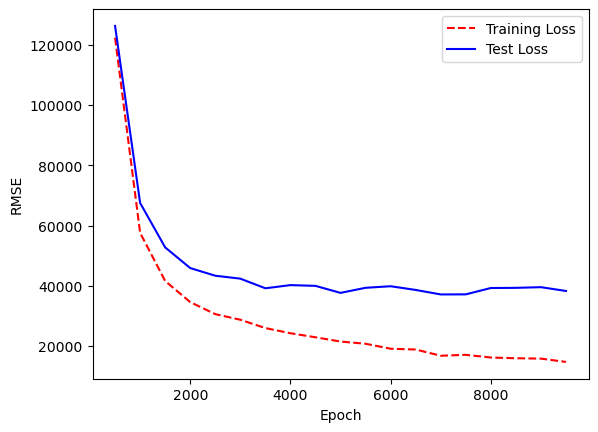

In [247]:
# parameters
num_epochs=10000
layer_archt=[1024,1024,1024,1024]
lr = 0.01
l2penalty = 0.001
leaky_param=0.10
dropout_p=0.2

model = NeuralNet(input_dim = len(X_train[0]), layers = layer_archt, leaky_param = leaky_param, dropout_p = dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = l2penalty)
criterion = nn.MSELoss()

train(model, tqdm(train_loader), criterion, optimizer, num_epochs)

In [343]:
test_rmse = rmse(test_loader, model)
print(f'Test RMSE: {test_rmse}')

Test RMSE: 35855.55912267999
